In [1]:
# import holy panda
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# make plots pretty
import matplotlib.pyplot as plt
%matplotlib inline
# list all parameters by "print(plt.rcParams)" command
plt.rcParams['figure.figsize'] = (7.5, 7.5)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
# generating range of points
a, b = (-1.,1.)
N = 100
n = 1
x = pd.np.linspace(a, b, N+1)

In [73]:
# generating jittery linear function y = kx+b
k, b = (-1.5, 1.0)
y = k*x+b
y[:50] = -k*x[:50]+b
noise = 0.1
y += pd.np.random.normal(loc=0., scale=noise, size=len(x))

In [21]:
# now pack x and y series into the dataframe
df = pd.DataFrame(zip(x,y), columns=['x','y'])

In [22]:
# function that adds slope and bias columns to argument dataframe 
# for N-point moving window
# http://www.clemson.edu/ces/phoenix/tutorials/excel/regression.html
def moving_linear_regression(data, N=10):
    _df = data[[0,1]].loc[:,]
    _df.columns = ('x','y')
    _df['s_x']  = 0.
    _df['s_y']  = 0.
    _df['s_xy'] = 0.
    _df['s_xx'] = 0.
    _df['s_yy'] = 0.
    sign = N/abs(N)
    N = abs(N)
    for i in range(N):
        _x = _df.x.shift(sign*i)
        _y = _df.y.shift(sign*i)
        _df.s_x += _x
        _df.s_y += _y
        _df.s_xy += _x*_y
        _df.s_xx += _x*_x
        _df.s_yy += _y*_y
    # now computing the results
    k  = N*_df.s_xy-_df.s_x*_df.s_y
    k /= N*_df.s_xx-_df.s_x*_df.s_x
    b = (_df.s_y-k*_df.s_x)/N
    # goodness of linear fir - r^2
    r  = N*_df.s_xy-_df.s_x*_df.s_y
    r *= r
    r /= N*_df.s_xx-_df.s_x*_df.s_x
    r /= N*_df.s_yy-_df.s_y*_df.s_y
    # packing it into the argument dataframe
    data['k'] = k
    data['r'] = r
    data['b'] = b
    del _df

The coefficient of determination, R squared, is used in linear regression theory in statistics as a measure of how well the regression equation fits the data. It is the square of R, the correlation coefficient, that provides us with the degree of correlation between the dependent variable, Y, and the independent variable X. R ranges from -1 to +1. If R equals +1, then Y is perfectly proportional to X, if the value of X increases by a certain degree, then the value of Y increases by the same degree. If R equals -1, then there is a perfect negative correlation between Y and X. If X increases, then Y will decrease by the same proportion. On the other hand if R=0, then there is no linear relationship between X and Y. R squared varies from 0 to 1. This gives us an idea of how well our regression equation fits the data. If R squared equals 1, then our best fit line passes through all the points in the data, and all of the variation in the observed values of Y is explained by its relationship with the values of X. For example if we get an R squared value of .80 then 80% of the variation in the values of Y is explained by its linear relationship with the observed values of X.

In [39]:
# adding dataframe columns for coefficients from moving window linead regression
Nw = 20
moving_linear_regression(df, -Nw) #future points
df.rename(columns={'k': 'kf', 'b': 'bf', 'r':'rf'}, inplace=True)
moving_linear_regression(df, +Nw) #past points
df.rename(columns={'k': 'kp', 'b': 'bp', 'r':'rp'}, inplace=True)
# df[df.index.duplicated()]

In [24]:
# linear predictions
df['reg_p'] = df.kp*df.x+df.bp
df['reg_f'] = df.kf*df.x+df.bf
# inflection point detection parameters
df['dk']=(df.kf-df.kp) #minimum - SnPt NO exposure. maximum SnPt NO recovery
# pick the poorest arm for the overall goodness of fit
df['mr'] = df[['rp','rf']].min(axis=1) 

Empty DataFrame
Columns: [x, y, kf, rf, bf, kp, rp, bp]
Index: []


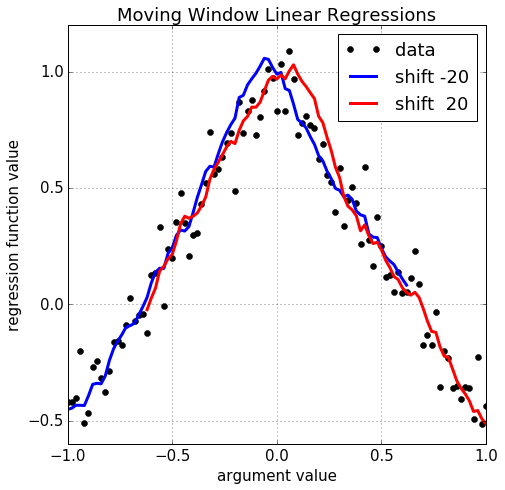

In [47]:
# plotting the data points and moving regression
plt.plot(df.x,df.y, linestyle=' ', marker='o', color='k', label="data")
plt.plot(df.x,df.reg_f, linewidth=3, color='b', label="shift -"+str(Nw))
plt.plot(df.x,df.reg_p, linewidth=3, color='r', label="shift  "+str(Nw))
plt.legend(loc=0)
plt.xlim(-1.,1.)
# plt.ylim(-0.51,1.01)
plt.title("Moving Window Linear Regressions")
plt.xlabel("argument value")
plt.ylabel("regression function value");

In [71]:
# identifying the inflection point of exposure
idx = df.dk.idxmin()
print "found point", idx, "\n", df.loc[idx,['dk','mr']]
# comparing it to the ground truth
print "ground truth 50\n", df.loc[50,['dk','mr']]

found point 48 
dk   -3.319973
mr    0.786415
Name: 48, dtype: float64
ground truth 50
dk   -2.942325
mr    0.713743
Name: 50, dtype: float64


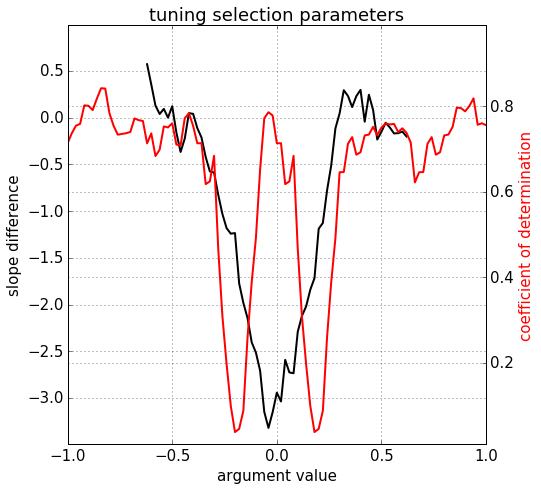

In [51]:
# exploring algorithm parameters
ax1 = plt.figure().add_subplot(111)
ax1.plot(df.x,df.dk, linewidth=2, color='k')
ax1.set_title("tuning selection parameters")
ax1.set_xlabel("argument value")
ax1.set_ylabel("slope difference")
ax1.set_ylim(-3.49,0.99)
ax2 = ax1.twinx()
ax2.plot(df.x,df.mr, linewidth=2, color='r')
ax2.set_ylabel("coefficient of determination", color='r')
ax2.set_ylim(0.01, 0.99);

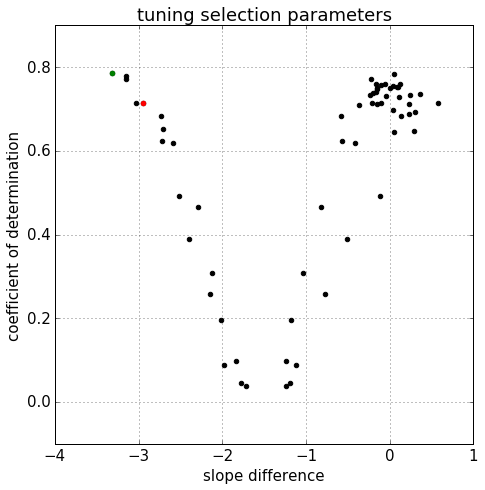

In [77]:
# establishing selection rule
plt.scatter(df.dk, df.mr, color='k')
# marking ground truth point in red
plt.scatter(df.dk[50],df.mr[50], color='r')
# marking detected point in green
plt.scatter(df.dk[idx],df.mr[idx], color='g')
plt.title("tuning selection parameters")
plt.xlabel("slope difference")
plt.ylabel("coefficient of determination");

Seems like selection rule for detecting inflection point could be something like absolute slope difference exceeding certain threshold and for passed entries identify those with the best goodness of fit